In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import time

%matplotlib notebook

In [73]:
class game2048():
    def __init__(self):
        self.width = 4
        self.height = 4
        self.ax = None
        self.fig = None
        
        # tile text position
        self.annot_dev = {1: [.09, -.18], 2: [.05, -.17], 
                          3: [.04, -.16], 4: [.02, -.16]}
        
        # tile colours
        self.grid_cols = {2: [238, 228, 218], 4: [236, 224, 202],
                          8: [242, 177, 121], 16: [247, 147, 102],
                          32: [245, 124, 97], 64: [244, 94, 59],
                          128: [237, 204, 99], 256: [237, 204, 99],
                          512: [236, 200, 80], 1024: [236, 200, 80],
                          2048: [0, 0, 0]}
        
        # font colours
        self.font_cols = {}
        for num in [2, 4]: 
            self.font_cols[num] = (129/255, 119/255, 109/255)
        for num in [8, 16, 32, 64, 128, 256, 512, 1024, 2048]:
            self.font_cols[num] = (1., 1., 1.)
            
        # tile text colours
        self.annot_font = {1: 34, 2: 30, 3: 26, 4: 22}
        
        self.reset()
        
    def state_to_cols(self):
        state_cols = np.zeros((self.width, self.height, 3))
        
        # Initialise base colors
        state_cols[:, :, 0] = 205
        state_cols[:, :, 1] = 193
        state_cols[:, :, 2] = 179
        
        # Annotate values
        for xy in np.argwhere(self.state > 0):
            
            # Update cell colors
            cell_value = self.state[xy[0], xy[1]]
            state_cols[xy[0], xy[1], 0] = self.grid_cols[cell_value][0]
            state_cols[xy[0], xy[1], 1] = self.grid_cols[cell_value][1]
            state_cols[xy[0], xy[1], 2] = self.grid_cols[cell_value][2]
           
        state_cols = state_cols.astype(int)
        
        return state_cols
    
    
    def render(self, wait=1, figsize=(4,4)):
        
        # Get RGB of this state
        state_cols = self.state_to_cols()
        
        # Start plot
        if self.ax is None:
            plt.ion()
            self.fig, self.ax = plt.subplots(1,1, figsize=(5,5))
            
        # Plot current state
        self.ax.clear()
        self.ax.imshow(np.flipud(state_cols))
                
        # Annotate values
        for xy in np.argwhere(self.state > 0):
            
            value = int(self.state[xy[0], xy[1]])
            self.ax.annotate(s=value, 
                             xy=(1. / self.width * xy[1] + self.annot_dev[len(str(value))][0], 
                                 1. / self.width * (self.width - xy[0]) + self.annot_dev[len(str(value))][1]), 
                             fontsize=self.annot_font[len(str(value))], color=self.font_cols[value], 
                             weight='bold', xycoords='axes fraction')
        
        # Title
        self.ax.set_title("Score: {}".format(int(self.score)), fontsize='18', weight='bold', 
                          color=(129./255., 119./255., 109/255.))
        
        # Ticks
        self.ax.set_xticks(np.arange(-.5, self.width, 1))
        self.ax.set_yticks(np.arange(-.5, self.height, 1))
        self.ax.set_xticklabels([])
        self.ax.set_yticklabels([])
        
        self.ax.set_xlim([-.55, self.width - 0.45])
        self.ax.set_ylim([-.55, self.height - 0.45])
        
        # Gridlines based on minor ticks
        self.ax.grid(color=(187/255, 173/255, 160/255), linestyle='-', linewidth=8)
        
        # Hide black ticks
        self.ax.tick_params(axis='x', colors='white')
        self.ax.tick_params(axis='y', colors='white')
        
        # Hide black frame around plot
        for spine in self.ax.spines.values():
            spine.set_edgecolor('white')
        
        # Update plot
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        time.sleep(wait)
        
        
    def add_new_tile(self):
        zero_idx = np.array(np.where(self.state == 0))
        sel_idx = np.random.choice(range(zero_idx.shape[1]))

        if np.random.uniform() < .8:
            self.state[zero_idx[0, sel_idx], zero_idx[1, sel_idx]] = 2.
        else:
            self.state[zero_idx[0, sel_idx], zero_idx[1, sel_idx]] = 4.
            
        
    def slide_left(self):
        
        reward = 0
        
        for row in range(self.state.shape[0]):
            
            # Ignore empty rows
            if np.sum(self.state[row, :]) > 0:
            
                # Only get non-zero values
                row_vals = self.state[row, :][self.state[row, :] > 0]
                dups = np.argwhere(np.diff(row_vals) == 0)

                # If all elements are the same and even num of elements
                cond1 = np.all(np.isclose(row_vals, row_vals[0])) 
                cond2 = len(row_vals) % 2 == 0
                if cond1 and cond2:
                    new_vals = np.ones(len(row_vals) // 2)
                    new_vals = new_vals * row_vals[0]*2
                    row_vals = new_vals.copy()
                    
                    # Add reward
                    reward += np.sum(row_vals)

                # Consider rows of type '2-2-2' -> '4-2'
                elif dups.shape[0] != 0:

                    if dups.shape[0] > 1:
                        diff_dups = np.diff(dups.squeeze())

                        del_idx = []
                        for idx, val in enumerate(diff_dups):
                            if val.size > 0:
                                if val == 1:
                                    del_idx.append(idx + 1)
                        dups = np.delete(dups, del_idx)

                    # Accumulate values
                    for dup in dups:
                        row_vals[dup] *= 2
                        
                        # Add reward
                        reward += row_vals[dup].squeeze()

                    # Removed cells that have been absorbed
                    row_vals = np.delete(row_vals, dups + 1)

                # Update state
                self.state[row, :] = 0
                self.state[row, :row_vals.shape[0]] = row_vals
                
        return reward
            
        
    def check_game_over(self):
        
        if np.where(self.state == 0)[0].shape[0] == 0:
            # Any par of consecutive equal values along axis 0
            cond1 = np.any(np.diff(self.state, axis=0) == 0)
            cond2 = np.any(np.diff(self.state, axis=1) == 0)
            
            # If no consecutive pairs in either direction, game over
            if not(cond1) and not(cond2):
                self.done = True
    
    
    def step(self, action):
        
        assert not(self.done)
        assert action in ['L', 'R', 'U', 'D']
        
        # Save previous state
        old_state = self.state.copy()
        
        if action == 'L':
            # slide left
            reward = self.slide_left()
            
        elif action == 'R':
            # flip L-R -> slide left -> flip L-R
            self.state = np.fliplr(self.state)
            reward = self.slide_left()
            self.state = np.fliplr(self.state)
            
        elif action == 'U':
            # rotate 90 -> slide left -> rotate -90
            self.state = np.rot90(self.state, k=1)
            reward = self.slide_left()
            self.state = np.rot90(self.state, k=-1)
            
        else:
            # rotate -90 -> slide left -> rotate 90
            self.state = np.rot90(self.state, k=-1)
            reward = self.slide_left()
            self.state = np.rot90(self.state, k=1)
            
        # Add new tile if new state is different
        if not(np.equal(self.state, old_state).all()):
            self.add_new_tile()
        
        # Update reward
        self.score += reward
        
        # Check if no more moves available
        self.check_game_over()

        return reward

        
    def reset(self):
        
        # Generate random initial positions for 2 2's
        v1, v2 = np.random.choice(np.arange(self.width * self.height), 2)
        
        # Generate empty board and populate random 2's
        self.state = np.zeros((self.width, self.height))
        self.state[v1 // self.width, v1 %  self.width] =  2
        self.state[v2 // self.width, v2 %  self.width] =  2
        self.score = 0
        self.done = False

<IPython.core.display.Javascript object>


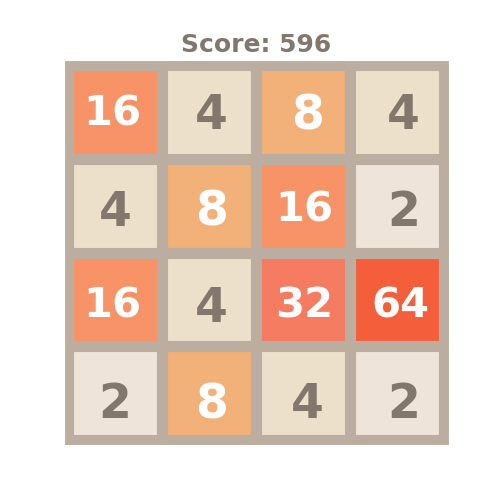

In [74]:
plt.ion()

env = game2048()
env.reset()
env.render()

for i in range(30):
    while not(env.done):
        action = np.random.choice(['D','U','L','R'])
        env.step(action)
        env.render(wait=.5)